In [19]:
import os
import pickle

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = 'Downloads/GP/data/'

data = []
labels = []
for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        data_aux = []

        x_ = []
        y_ = []

        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

            data.append(data_aux)
            labels.append(dir_)

f = open('Downloads/GP/data/data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()

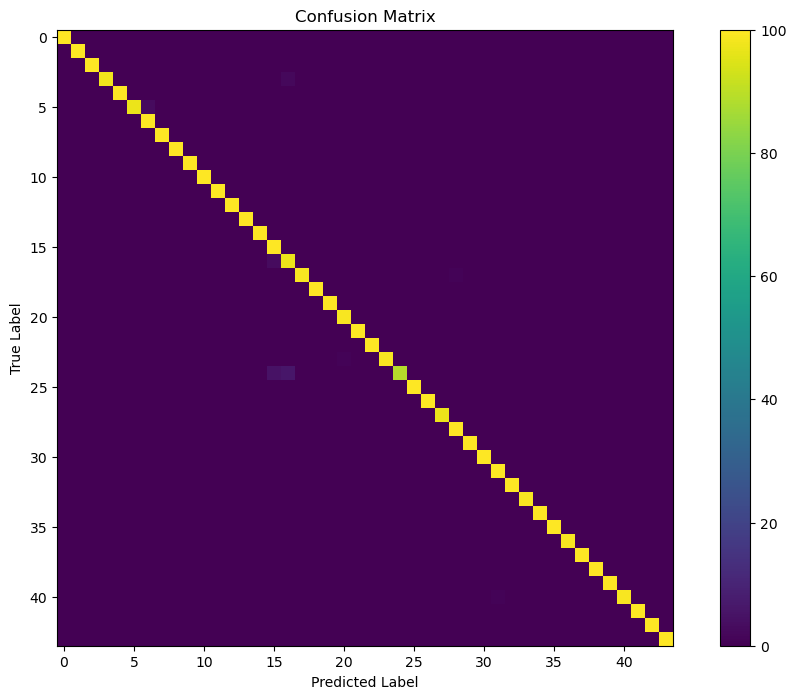

[99.51635846 99.71550498 99.63015647 99.54480797 99.65860597]% of samples were classified correctly!


In [20]:
import pickle
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
data_dict = pickle.load(open('Downloads/GP/data1/data.pickle', 'rb'))
data = pad_sequences(data_dict['data'], dtype='float32')
labels = np.asarray(data_dict['labels'])

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

# Initialize and train RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2)
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(12, 8))
plt.imshow(conf_matrix, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x_train, y_train, cv=5)

print('{}% of samples were classified correctly!'.format(scores * 100))


f = open('Downloads/GP/data/model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

In [21]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [22]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results2 = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results2

In [23]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections


In [24]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                              ) 
#     # Draw left hand connections
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
#                               mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
#                               mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
#                               ) 
#     # Draw right hand connections  
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
#                               mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
#                               mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
#                               )


In [25]:
##   video_path = 'path/to/your/video/file.mp4'
##   cap = cv2.VideoCapture(video_path)

In [1]:
import pickle
import cv2
import mediapipe as mp
import numpy as np

# Load the pre-trained model
model_dict = pickle.load(open('Downloads/GP/data/model.p', 'rb'))
model = model_dict['model']

# Initialize video capture
cap = cv2.VideoCapture(0)

# Set up MediaPipe models for holistic and face detection
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize the models
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.3)

# Labels for hand gesture recognition
labels_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'Iam', 4: 'del', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L',
               13: 'M', 14: 'N', 15: 'nothing', 16: 'O', 17: 'P', 18: 'Q', 19: 'R', 20: 'S', 21: ' ', 22: 'T', 23: 'U',
               24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z', 29: '0', 30: '1', 31: '2', 32: '3', 33: '4', 34: '5', 35: '6',
               36: '7', 37: '8', 38: '9', 39: 'Love' , 40: 'You' , 41: 'Ok' , 42: 'Thanks' , 43: 'How' , 44: 'are'}
word = ""

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    if not ret:
        break

    H, W, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform face detection
    face_results = face_detection.process(frame_rgb)

    if face_results.detections:
        for detection in face_results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = (
                int(bboxC.xmin * iw),
                int(bboxC.ymin * ih),
                int(bboxC.width * iw),
                int(bboxC.height * ih),
            )

            cv2.rectangle(frame, bbox, (0, 255, 0), 2)

    # Perform hand and holistic detections
    results = holistic.process(frame_rgb)
    hand_results = hands.process(frame_rgb)
    
    # Process hand landmarks
    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x)
                data_aux.append(y)
                x_.append(x)
                y_.append(y)

        for i in range(len(hand_landmarks.landmark)):
            x = hand_landmarks.landmark[i].x
            y = hand_landmarks.landmark[i].y
            data_aux.append(x - min(x_))
            data_aux.append(y - min(y_))
          

        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10
        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10

        # Ensure that data_aux has the correct number of features
        if len(data_aux) != 84:
            print("Error: Incorrect number of features. Check your feature extraction process.")
        else:
            # Make predictions using the model
            prediction = model.predict([np.asarray(data_aux)])
            predicted_character = labels_dict[int(prediction[0])]
            
            # print character if 'P' or 'p' is pressed
            if key == ord('P') or key == ord('p'):
                print(predicted_character)
                if(len(predicted_character)==1):
                  word += predicted_character
                else :   
                  word += " " + predicted_character
                

            # Draw the bounding box and predicted character on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
            cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('frame', frame)

    # Break the loop if 'Q' or 'q' is pressed
    key = cv2.waitKey(1) & 0xFF
    if key == ord('Q') or key == ord('q'):
        break
print(word)
# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()



Iam
Ok
 
I
Love
You
 Iam Ok I Love You


In [2]:
from happytransformer import HappyTextToText
happy_tt = HappyTextToText("T5", "prithivida/grammar_error_correcter_v1")
from happytransformer import TTSettings
top_k_sampling_settings = TTSettings(do_sample=True, top_k=50, temperature=0.7, min_length=1, max_length=10)


C:\Users\Salah\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
05/18/2024 23:22:32 - INFO - happytransformer.happy_transformer -   Using device: cpu
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32100. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [3]:
import re
def remove_frequent_words(str):
  words=re.findall(r'\b\w+\b',str.lower())
  new =words[0];
  x=words[0]
  new+=" "
  for i in words:
    if x!= i:
      x=i
      new+=i+" "
  return new+'.'

In [4]:
str=remove_frequent_words(word)
print(str)
result_5 = happy_tt.generate_text(str, args=top_k_sampling_settings)
print(result_5.text)

05/18/2024 23:22:34 - INFO - happytransformer.happy_transformer -   Moving model to cpu
05/18/2024 23:22:34 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


iam ok i love you .
iam ok i love you
